# Weather Py
----------------------

#### Analysis of Trends - Jim Bentley

1. Random city data - All cities randomly chosen in the sample are evenly spread above, below the equator and accross the globe.

2. Temperatures appear stable in the Southern hemisphere.  The temperature drops the further north of the equator that you look at. This is backed up by the linear regression analysis.  The northern hemisphere has a strong positive correlation between temperature and latitude.  Compared to the southern hemisphere that has weaker correlation.
3. There is very weak or no corelation between latitude and other weather measures including:
    * Humidity 
    * Cloud Cover
    * Wind Speed
    
    This is for both the Northern and Southern hemispheres.

In [31]:
# import dependencies for the entire workbook
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import datetime
from scipy import stats

## Generate Cities List

 I performed a 'pip install citypy' to obtain the library. 

 Uniform random can be used to get uniformly distributed sample data

 600 cities chosen to ensure a sample set over 500
 

In [2]:
# Need the following library to get a list of cities
from citipy import citipy
from random import uniform

# Procedure to return a random lat and long coordinate
def newpoint():
   return uniform(-180,180), uniform(-90, 90)

# Find the closest city to each random coordinate (800)
cities = [] 
while len(cities) < 600:
    point = newpoint()
    city = citipy.nearest_city(point[0], point[1]).city_name
    # check if the city is not already chosen
    if city not in cities:
        cities.append(city)
    
# Check city count = 600
print(len(cities))

600


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).

Solution includes a check for duplicates - All cities in the list are unique

Only use cities with weather details returned from Open Weather. 

In [3]:
from api_keys import weather_api_key

url = "http://api.openweathermap.org/data/2.5/weather?"
units='imperial'

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# set up lists to hold reponse info
citynum = []
cityname = []
citytemp = []
cityhumidity = []
citylatitude = []
citycloudiness = []
citywindspeed = []

x = 0
valid_cities = 0

# Get weather data
for city in cities:
    x += 1
    try:
        response = requests.get(query_url + city).json()
        print(f"Processing record {x}: {response['name']} id={response['id']}")
        valid_cities +=1
        citynum.append(valid_cities)
        cityname.append(city)
        citytemp.append(response['main']['temp'])
        cityhumidity.append(response['main']['humidity'])
        citylatitude.append(response['coord']['lat'])
        citycloudiness.append(response['clouds']['all'])
        citywindspeed.append(response['wind']['speed'])
    except KeyError:
        print(f"Processing record {x}: {city} - No weather details available")
    
    # Break out of loop when we have enough weather records
    if valid_cities > 520:
        break

113: Chui id=3443061
Processing record 114: Cidreira id=3466165
Processing record 115: Camocim id=3403687
Processing record 116: Stranraer id=2636719
Processing record 117: Torbay id=6167817
Processing record 118: Gopālpur id=1270961
Processing record 119: Podporozh'ye id=508034
Processing record 120: Pauini id=3662927
Processing record 121: louisbourg - No weather details available
Processing record 122: Phalombe id=924206
Processing record 123: Hithadhoo id=1282256
Processing record 124: Mossamedes id=3347019
Processing record 125: Swanton id=5173514
Processing record 126: Kamenka id=553766
Processing record 127: São João da Barra id=3448903
Processing record 128: Karad id=1267904
Processing record 129: Henties Bay id=3356832
Processing record 130: amderma - No weather details available
Processing record 131: Bonavista id=5905393
Processing record 132: Iqaluit id=5983720
Processing record 133: Tiznit Province id=2527087
Processing record 134: Bull Savanna id=3491161
Processing record

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
weather_dict = {
    "Number": citynum,
    "City": cityname,
    "Latitude": citylatitude,
    "Temp": citytemp,
    "Humidity" : cityhumidity,
    "Cloudiness" : citycloudiness,
    "Windspeed" : citywindspeed 
}

weather_data = pd.DataFrame(weather_dict)
weather_data

,Number,City,Latitude,Temp,Humidity,Cloudiness,Windspeed
0,1,caconda,-13.7333,57.07,83,72,0.76
1,2,ushuaia,-54.8000,48.20,87,75,8.05
2,3,grand gaube,-20.0064,84.99,74,14,8.99
3,4,outjo,-20.1167,61.38,53,76,6.67
4,5,hamirpur,25.9500,69.48,30,0,4.88
...,...,...,...,...,...,...,...
516,517,kyabe,9.4515,72.90,24,0,4.14
517,518,hammerfest,70.6634,19.40,93,40,8.61
518,519,tabou,4.4230,77.52,89,1,4.83
519,520,tharad,24.3961,78.15,17,0,3.80


In [5]:
weather_data.to_csv("output_data\weather_data.csv", index=False)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

Note: Most times I run this no records are found above 100%

In [6]:
high_humidity = weather_data.loc[weather_data['Humidity']>100]
high_humidity.head()

,Number,City,Latitude,Temp,Humidity,Cloudiness,Windspeed


In [9]:
#  Get the indices of cities that have humidity over 100%.
high_humidity_index = high_humidity.index

In [10]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_data.drop(high_humidity_index, inplace=False)
len(clean_city_data)

521

In [11]:
# Reset index annd remove unecessary columns.
clean_city_data = clean_city_data.reset_index(inplace=False)
clean_city_data = clean_city_data[['City', 'Latitude', 'Temp', 'Humidity', 'Cloudiness', 'Windspeed']]
clean_city_data.head()

,City,Latitude,Temp,Humidity,Cloudiness,Windspeed
0,caconda,-13.7333,57.07,83,72,0.76
1,ushuaia,-54.8000,48.20,87,75,8.05
2,grand gaube,-20.0064,84.99,74,14,8.99
3,outjo,-20.1167,61.38,53,76,6.67
4,hamirpur,25.9500,69.48,30,0,4.88


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [12]:
# store today's analysis date
now = datetime.date.today().strftime('%d-%b-%Y')

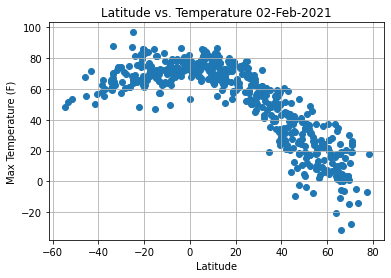

In [13]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Temp)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeTemp.png")
plt.show()

### Notes for Analysis Report
* Temperature is stable for the southern hemisphere, but decreases significantly the further north you go above the equator.

## Latitude vs. Humidity Plot

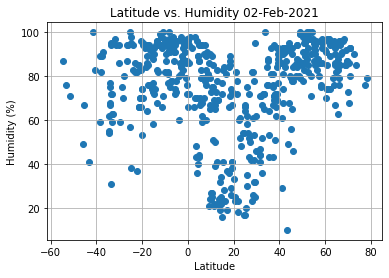

In [14]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Humidity)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeHumidity.png")
plt.show()

### Notes for Analysis Report
* Humidity appears to be lower just above the equator.

## Latitude vs. Cloudiness Plot

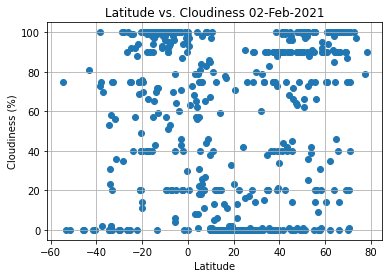

In [15]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Cloudiness)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeCloud.png")
plt.show()

### Notes for Analysis Report
* Cloud cover appears scattered evenly accross the globe

## Latitude vs. Wind Speed Plot

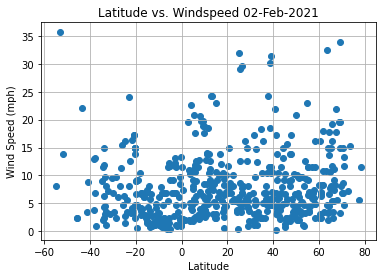

In [16]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Windspeed)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Windspeed {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeWind.png")
plt.show()

### Notes for Analysis Report
* Wind speed does not seem to different at certain latitudes

## Linear Regression

In [17]:
# Split the dataset into hemispheres
north_hemisphere = clean_city_data.loc[clean_city_data.Latitude > 0]
south_hemisphere = clean_city_data.loc[clean_city_data.Latitude < 0]

print(f"North = {len(north_hemisphere)} records, South = {len(south_hemisphere)} records")

North = 361 records, South = 160 records


### Notes for Analysis Report
* It appears to be more cities located in the Northern Hemisphere.  Or more cities where weather details are recorded. 

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.8102171498731584


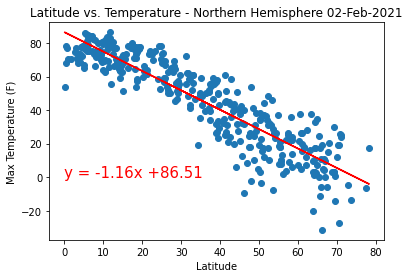

In [45]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Temp
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatTempRegression.png")

plt.show()

### Notes for Analysis Report
* Strong positive correlation between temperature and latitude

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.1997859704492127


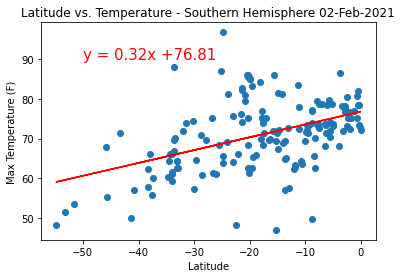

In [46]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Temp
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,90),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatTempRegression.png")

plt.show()

### Notes for Analysis Report
* Weaker correlation in the southern hemisphere.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.22449611752841506


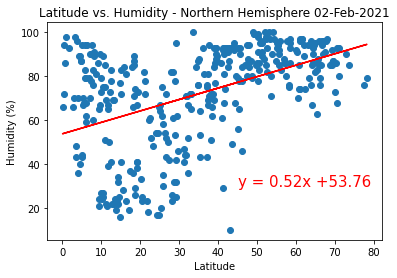

In [69]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Humidity
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,30),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatHumidRegression.png")

plt.show()

### Notes for Analysis Report
* Weak correlation between humidity and lattitude in the northern hemisphere.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.12929221019117182


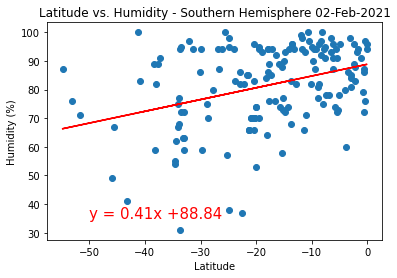

In [67]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Humidity
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,35),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatHumidRegression.png")

plt.show()

### Notes for Analysis Report
* Again some, but weaker correlation in the southern hemisphere 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.16395190075382662


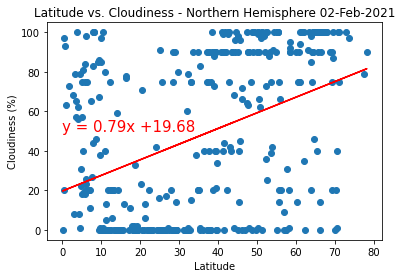

In [66]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Cloudiness
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatCloudRegression.png")

plt.show()

### Notes for Analysis Report
* Weak correlation between latitude and cloud cover

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.1671824241262153


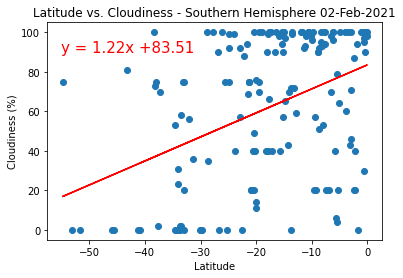

In [62]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Cloudiness
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,90),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatCloudRegression.png")

plt.show()

### Notes for Analysis Report
* Weak correlation in southern hemisphere too

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.0011925054214773922


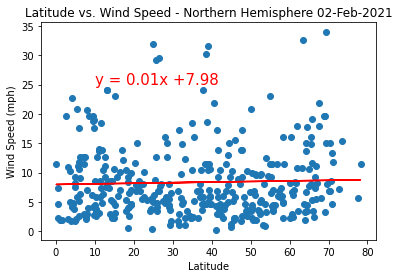

In [63]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Windspeed
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,25),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Wind Speed - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatWindRegression.png")

plt.show()

### Notes for Analysis Report
* No correlation

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.09371549223314976


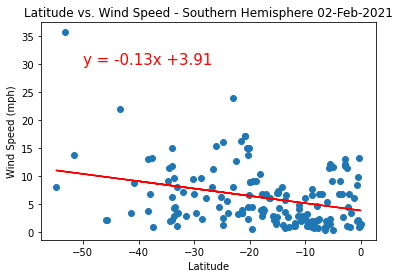

In [64]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Windspeed
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,30),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Wind Speed - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatWindRegression.png")

plt.show()

### Notes for Analysis Report
* No correlation